# 随机梯度下降法
前面我们介绍了梯度下降法的数学原理，下面我们通过例子来说明一下随机梯度下降法，我们分别从 0 自己实现，以及使用 pytorch 中自带的优化器

In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18.0, 16.0)

## Import MNIST dataset

In [4]:
def data_tf(x):
    x = np.array(x, dtype='float32') / 255 # 将数据变到 0 ~ 1 之间
    x = (x - 0.5) / 0.5 # 标准化
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

# 下载MNIST数据
将download=True
```python
train_set = MNIST('~/Documents/pytorch/DeepLearning/mnist', train=True, transform=data_tf, download=True) 
```

In [7]:
train_set = MNIST('~/Documents/pytorch/DeepLearning/mnist', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('~/Documents/pytorch/DeepLearning/mnist', train=False, transform=data_tf)

## Data preprocess

### 定义 loss 函数

In [5]:
criterion = nn.CrossEntropyLoss()

If we have two classes, the equation of cross entropyloss is:  $−(ylog(p)+(1−y)log(1−p))$


If $M$ is more than two, which is: $−\sum^{M}_{c=1}y_{o,c}log(p_{o,c})$

### 梯度计算

随机梯度下降法非常简单，公式就是
$$
\theta_{i+1} = \theta_i - \eta \nabla L(\theta)
$$
非常简单，我们可以从 0 开始自己实现

In [6]:
def sgd_update(parameters, lr):
    for param in parameters:
        param.data = param.data - lr * param.grad.data

### Random Gradient Descent

我们可以将 batch size 先设置为 1，看看有什么效果

In [7]:
train_data = DataLoader(train_set, batch_size=1, shuffle=True)

In [8]:
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

In [9]:
# START TRAINING
losses1 = []
idx = 0

start = time.time() # starting time
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)

        # feed forward propagation
        out = net(im)
        loss = criterion(out, label)

        # back propagation
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(), 1e-2) # learning rate

        # recording loss
        train_loss += loss.item()

        if idx % 30 == 0:
            losses1.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'.format(e, train_loss / len(train_data)))

end = time.time() # end time
print('Total Time: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.350547
epoch: 1, Train Loss: 0.216299
epoch: 2, Train Loss: 0.174617
epoch: 3, Train Loss: 0.153002
epoch: 4, Train Loss: 0.140482
Total Time: 213.88184 s


In [31]:
def x_e(list_):
    out = [0] * len(list_)
    out[0] = 0
    for i in range(1, len(list_)):
        out[i-1] = 0.8 * out[i - 1] + 0.2 * list_[i]
    return out

In [32]:
out_ = x_e(losses1)

No handles with labels found to put in legend.


<Figure size 1296x1152 with 0 Axes>

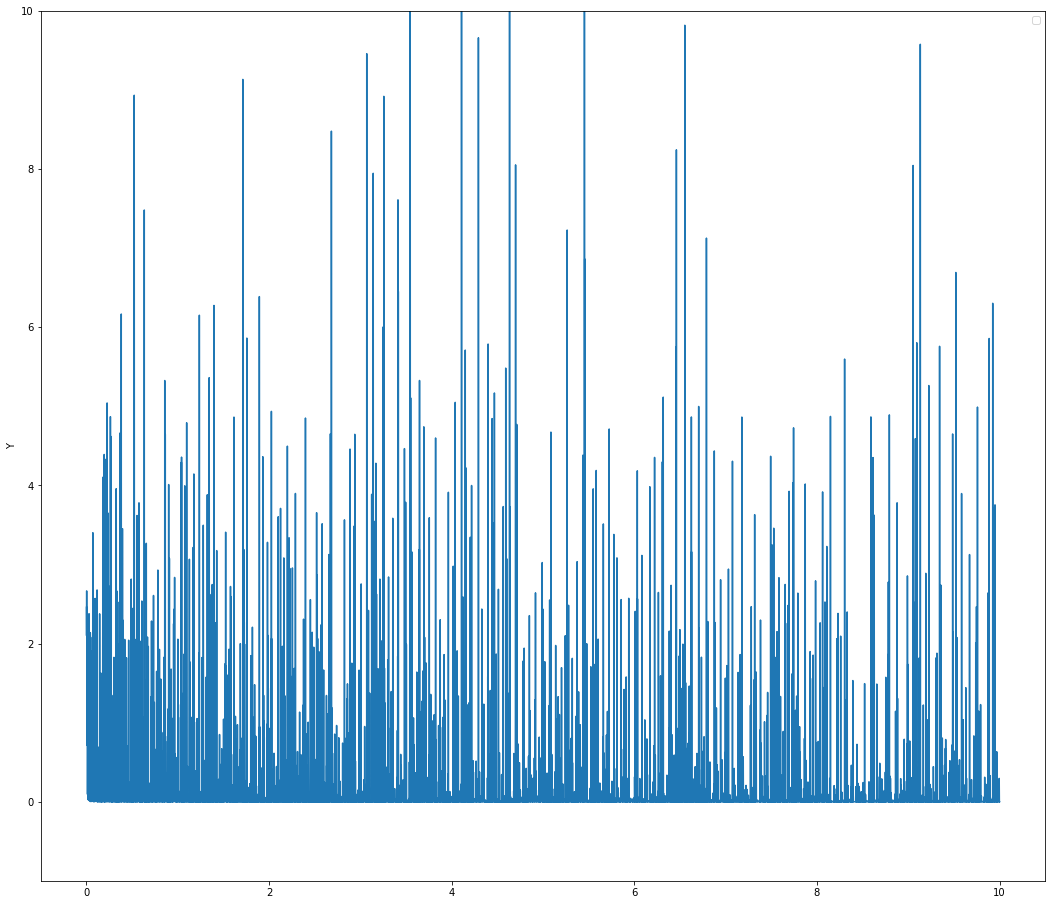

In [22]:
fig = plt.figure()
fig, ax = plt.subplots(1, 1)

x_axis = np.linspace(0, 10, len(losses1), endpoint=True)
# plt.semilogy(x_axis, losses1, label='batch_size=1')
ax.plot(x_axis, losses1)
ax.set_ylabel('Y')
ax.set_ylim(-1, 10)
plt.legend(loc='best')
plt.show()

可以看到，loss 在剧烈震荡，因为每次都是只对一个样本点做计算，每一层的梯度都具有很高的随机性，而且需要耗费大量的时间

## Batch Gradient Descent

In [34]:
train_data = DataLoader(train_set, batch_size=128, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 开始训练
losses2 = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(), 1e-2)
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses2.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('Total time: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 1.031966
epoch: 1, Train Loss: 0.451415
epoch: 2, Train Loss: 0.376799
epoch: 3, Train Loss: 0.343697
epoch: 4, Train Loss: 0.322809
Total time: 26.61237 s


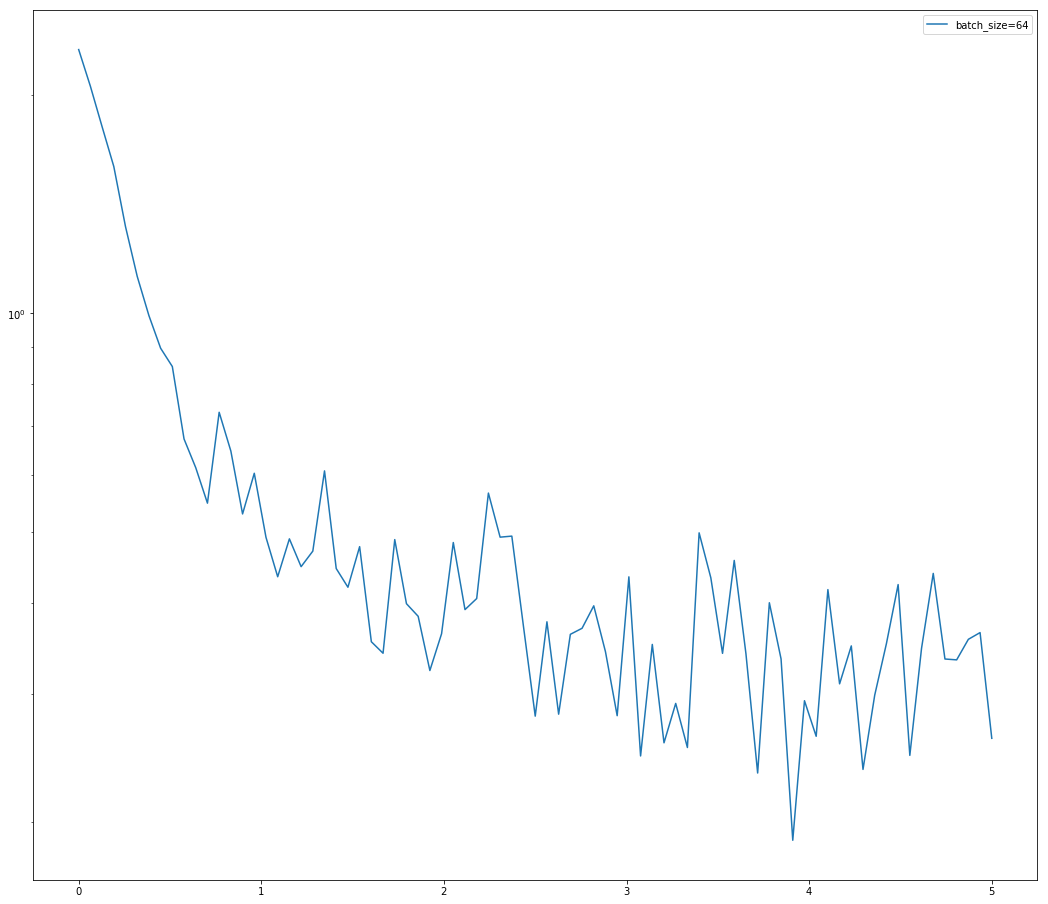

In [35]:
x_axis = np.linspace(0, 5, len(losses2), endpoint=True)
plt.semilogy(x_axis, losses2, label='batch_size=64')
plt.legend(loc='best')

通过上面的结果可以看到 loss 没有 batch 等于 1 震荡那么距离，同时也可以降到一定的程度了，时间上也比之前快了非常多，因为按照 batch 的数据量计算上更快，同时梯度对比于 batch size = 1 的情况也跟接近真实的梯度，所以 batch size 的值越大，梯度也就越稳定，而 batch size 越小，梯度具有越高的随机性，这里 batch size 为 64，可以看到 loss 仍然存在震荡，但这并没有关系，如果 batch size 太大，对于内存的需求就更高，同时也不利于网络跳出局部极小点，所以现在普遍使用基于 batch 的随机梯度下降法，而 batch 的多少基于实际情况进行考虑

下面我们调高学习率，看看有什么样的结果

In [36]:
train_data = DataLoader(train_set, batch_size=128, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

# 开始训练
losses3 = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_update(net.parameters(), 1) # 使用 1.0 的学习率
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses3.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 2.671618
epoch: 1, Train Loss: 2.303478
epoch: 2, Train Loss: 2.309607
epoch: 3, Train Loss: 2.302925
epoch: 4, Train Loss: 2.303184
使用时间: 26.16482 s


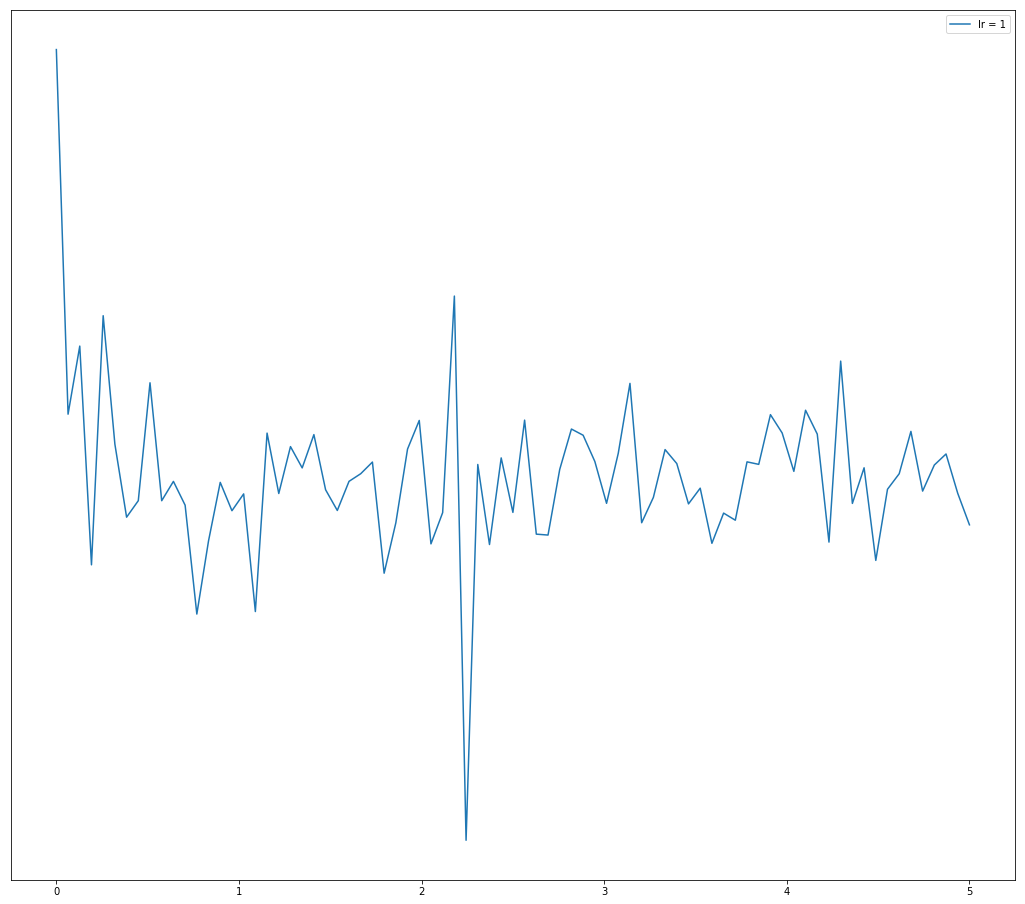

In [37]:
x_axis = np.linspace(0, 5, len(losses3), endpoint=True)
plt.semilogy(x_axis, losses3, label='lr = 1')
plt.legend(loc='best')

可以看到，学习率太大会使得损失函数不断回跳，从而无法让损失函数较好降低，所以我们一般都是用一个比较小的学习率

实际上我们并不用自己造轮子，因为 pytorch 中已经为我们内置了随机梯度下降发，而且之前我们一直在使用，下面我们来使用 pytorch 自带的优化器来实现随机梯度下降

In [38]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimzier = torch.optim.SGD(net.parameters(), 1e-2)
# 开始训练

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimzier.zero_grad()
        loss.backward()
        optimzier.step()
        # 记录误差
        train_loss += loss.item()
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.749033
epoch: 1, Train Loss: 0.363988
epoch: 2, Train Loss: 0.318582
epoch: 3, Train Loss: 0.291839
epoch: 4, Train Loss: 0.269516
使用时间: 28.37138 s


In [ ]:
x_axis = np.linspace(0, 5, len(losses3), endpoint=True)
plt.semilogy(x_axis, losses3, label='lr = 1')
plt.legend(loc='best')